# setup

In [2]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

In [3]:
pq_path = "../data/flightdata/flights_2022.parquet"
csv_path = "../data/flightdata/flights_2022.csv"

In [4]:
parquet = pq.read_table(pq_path)
df = pd.read_csv(csv_path)

# eda

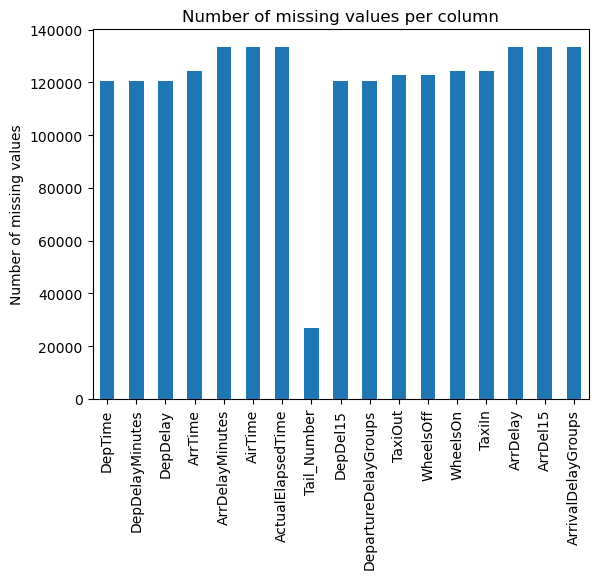

In [5]:
# Generate a bar chart for number of missing values per column in the dataset
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values.plot(kind="bar")
plt.title("Number of missing values per column")
plt.ylabel("Number of missing values")
plt.show()

In [6]:
# Drop rows with missing values
df = df.dropna()

In [7]:
# Get the columns that have missing values
missing_columns = missing_values.index
print(missing_columns)
print(range(len(missing_columns)))

missing_cols_idx_to_keep = [0, 2, 3, 4, 8, 14, 15, 16]

missing_cols_to_remove = [missing_columns[i] for i in range(len(missing_columns)) if i not in missing_cols_idx_to_keep]
print(missing_cols_to_remove)

Index(['DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime', 'ArrDelayMinutes',
       'AirTime', 'ActualElapsedTime', 'Tail_Number', 'DepDel15',
       'DepartureDelayGroups', 'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn',
       'ArrDelay', 'ArrDel15', 'ArrivalDelayGroups'],
      dtype='object')
range(0, 17)
['DepDelayMinutes', 'AirTime', 'ActualElapsedTime', 'Tail_Number', 'DepartureDelayGroups', 'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn']


In [8]:
missing_cols_to_keep = [missing_columns[i] for i in range(len(missing_columns)) if i in missing_cols_idx_to_keep]
print(missing_cols_to_keep)

['DepTime', 'DepDelay', 'ArrTime', 'ArrDelayMinutes', 'DepDel15', 'ArrDelay', 'ArrDel15', 'ArrivalDelayGroups']


In [20]:
df.columns

Index(['FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted',
       'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime',
       'ArrDelayMinutes', 'AirTime', 'CRSElapsedTime', 'ActualElapsedTime',
       'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
       'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline',
       'Flight_Number_Marketing_Airline', 'Operating_Airline',
       'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline',
       'Tail_Number', 'Flight_Number_Operating_Airline', 'OriginAirportID',
       'OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName',
       'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName',
       'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'DepDel15',
       'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOu

# notes

CRSDepTime - scheduled departure time (local, hhmm)

departureDelayMinutes - departure delay (in minutes) <- remove this one

departureDelay - departure delay (in minutes) but early departures are negative

In [43]:
cols_to_drop = [
    "Operated_or_Branded_Code_Share_Partners",
    "DOT_ID_Marketing_Airline",
    "DOT_ID_Operating_Airline",
    "IATA_Code_Marketing_Airline",
    "IATA_Code_Operating_Airline",
    "OriginAirportSeqID",
    "OriginCityMarketID",
    "DestAirportSeqID",
    "DestCityMarketID",
    "DepTimeBlk",
    "ArrDelayMinutes",
    "ArrivalDelayGroups",
    "ArrTimeBlk",
    "DistanceGroup",
    "DivAirportLandings",
    "DepDelayMinutes",
    "AirTime",
    "ActualElapsedTime",
    "Tail_Number",
    "DepartureDelayGroups",
    "OriginAirportID",
    "OriginCityName",
    "OriginState",
    "OriginStateFips",
    "OriginStateName",
    "OriginWac",
    "DestAirportID",
    "DestCityName",
    "DestState",
    "DestStateFips",
    "DestStateName",
    "DestWac",
    "Year",
    "Month",
    "DayofMonth",
    "Quarter",
    "Cancelled",
    "Diverted",
]

new_cols = [
    "flightDate",
    "fullAirlineName",
    "originCode",
    "destinationCode",
    "scheduledDepartureTime",
    "actualDepartureTime",
    "departureDelayMinutes",
    "actualArrivalTime",
    "scheduledAirTime",
    "distanceMiles",
    "dayOfWeek",
    "marketingAirlineNetwork",
    "flightNumberMarketingAirline",
    "operatingAirlineCode",
    "flightNumberOperatingAirline",
    "departureDelayBool",
    "taxiOut",
    "wheelsOff",
    "wheelsOn",
    "taxiIn",
    "scheduledArrivalTime",
    "arrivalDelayMinutes",
    "arrivalDelayBool",
]

len(new_cols)

23

In [44]:
test_dropped_df = df.drop(cols_to_drop, axis=1, inplace=False)
print((test_dropped_df.columns))
print(len(test_dropped_df.columns))
test_dropped_df.sample().head(1)

Index(['FlightDate', 'Airline', 'Origin', 'Dest', 'CRSDepTime', 'DepTime',
       'DepDelay', 'ArrTime', 'CRSElapsedTime', 'Distance', 'DayOfWeek',
       'Marketing_Airline_Network', 'Flight_Number_Marketing_Airline',
       'Operating_Airline', 'Flight_Number_Operating_Airline', 'DepDel15',
       'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn', 'CRSArrTime', 'ArrDelay',
       'ArrDel15'],
      dtype='object')
23


,FlightDate,Airline,Origin,Dest,CRSDepTime,DepTime,DepDelay,ArrTime,CRSElapsedTime,Distance,...,Operating_Airline,Flight_Number_Operating_Airline,DepDel15,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15
2120831,2022-05-12,Envoy Air,MIA,SDF,1542,1616.0,34.0,1915.0,163.0,910.0,...,MQ,3616,1.0,34.0,1650.0,1908.0,7.0,1825,50.0,1.0


In [45]:
dropped_df = df.drop(cols_to_drop, axis=1, inplace=False)
dropped_df.columns = new_cols
dropped_df.sample().head(1)

,flightDate,fullAirlineName,originCode,destinationCode,scheduledDepartureTime,actualDepartureTime,departureDelayMinutes,actualArrivalTime,scheduledAirTime,distanceMiles,...,operatingAirlineCode,flightNumberOperatingAirline,departureDelayBool,taxiOut,wheelsOff,wheelsOn,taxiIn,scheduledArrivalTime,arrivalDelayMinutes,arrivalDelayBool
577783,2022-04-08,"Commutair Aka Champlain Enterprises, Inc.",TYS,IAD,1001,957.0,-4.0,1140.0,103.0,420.0,...,C5,4977,0.0,32.0,1029.0,1133.0,7.0,1144,-4.0,0.0


In [12]:
def convert_float_time(row) -> dt.datetime:
    """Converts a float time to a datetime object"""
    # convert flightDate value to string it is in format YYYYMMDD
    flight_date = str(row["flightDate"])

    to_dt_columns = [
        "scheduledDepartureTime",
        "actualDepartureTime",
        "scheduledArrivalTime",
        "actualArrivalTime",
    ]

    for column in to_dt_columns:
        # if the value is a datetime object, skip it
        if isinstance(row[column], dt.datetime):
            continue

        time = str(int(row[column])).zfill(4)
        hour = time[:2]
        minute = time[2:]

        if hour == "24":
            hour = "00"

        row[column] = dt.datetime.strptime(
            f"{flight_date} {hour}:{minute}", "%Y-%m-%d %H:%M"
        )

    return row

In [13]:
# Convert scheduledDepartureTime, actualDepartureTime, scheduledArrivalTime, actualArrivalTime to datetime they are floats in format HHMM in 24hour time
dropped_df = dropped_df.apply(convert_float_time, axis=1)

# Drop rows with missing values again
cleaned_full_data = dropped_df.dropna()

cleaned_full_data[["flightDate", "scheduledArrivalTime"]].sample().head(1)

,flightDate,scheduledArrivalTime
1899328,2022-05-06,2022-05-06 15:53:00
